# Build a CNN model

In [1]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tools import pretraitement
import random
import os
import json
import sys
import time

2021-12-09 11:49:45.782938: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-09 11:49:45.782964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Chargement du jeu de données
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = tf.keras.datasets.cifar10.load_data()

# pretraitement des données
(x_train, y_train) = pretraitement.normalize_dataset(x_train_origin, y_train_origin)

(x_test, y_test) = pretraitement.normalize_dataset(x_test_origin, y_test_origin)

del x_train_origin
del x_test_origin
del y_train_origin
del y_test_origin

assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 10)
assert y_test.shape == (10000, 10)

In [3]:
parametres = { 'data': {
    'x_train_shape': x_train.shape,
    'y_train_shape': y_train.shape,
    'x_test_shape': x_test.shape,
    'y_test_shape': y_test.shape,
    'augmented_data': False
}}

## Construction d'un modèle

Nous commençons par créer un modèle simple pour avoir un premier résultat. Nous verrons après comment modifier sa structure afin d'avoir de meilleurs résultats.

### Structure du modèle

Nous avons défini, pour commencer un modèle avec les couches suivantes :

- La  première, c'est la couche d'entrée. (input_shape)
- Puis nous avons ajouté 3 couches de convolution 2D de dimensions de 32, 64 et 128 qui sont  chaqu'une suivit d'une couche de MaxPooling
- Puis viens une couche `Flatten` pour aplatir l'image obtenue afin de la passer à un réseau `dense`
- Enfin une couche `dense` de 256 neurones avec comme fonction d'activation `relu`

In [4]:
# Construction d'un CNN
input_shape=(32, 32, 3)

# La base CNN
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Ajout de couches denses vers la fin du model
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

2021-12-09 11:50:20.130180: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-09 11:50:20.130239: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 11:50:20.130266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pop-os): /proc/driver/nvidia/version does not exist
2021-12-09 11:50:20.130528: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Durant ce processus, en garde en mémoire chaque informations qui nous a amené à un modèle. Pour cela, nous avons défini un dictionnaire `parametres` qui garde en mémoire toute sorte d'informations.

- Data: informations sur les données utilisées (taille, augmentation ...)
- Structure: les informations concernant la structure du réseau
- Training: informations concernant les paramètre d'entrainement du réseau (learning_rate ...)
- Results: informations sur les résultats obtenues. (accuracy, loss, validation_accuracy ainsi que l'historique...)

In [5]:
model_config = json.loads(model.to_json())

layers_information = []
l=model_config['config']['layers']

for i in range(len(l)):
    layers_information.append({
        'type': l[i]['class_name'],
        'config': l[i]['config']
    })

parametres['structure'] = {'layers' : layers_information}

## Model training

In [6]:
# Compiling model

## training parameters
learning_rate = 0.001
loss='mean_squared_error'
#loss='categorical_crossentropy'
optimizers={'adam':Adam(learning_rate=learning_rate)}
optimizer = 'adam'
metrics=['accuracy']
epochs=5
batch_size=128

parametres['training'] = {
    'learning_rate': learning_rate,
    'loss': loss,
    'optimizer': optimizer,
    'metrics': metrics,
    'epochs': epochs,
    'batch_size': batch_size
}

In [7]:
model.compile(optimizer=optimizers[optimizer],
              loss=loss,
              metrics=metrics)

In [8]:
history = model.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, 
                    validation_data=(x_test, y_test))

history2 = None

2021-12-09 11:51:23.704954: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.
2021-12-09 11:51:24.479828: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
391/391 [==============================] - 54s 132ms/step - loss: 0.0671 - accuracy: 0.4622 - val_loss: 0.0580 - val_accuracy: 0.5567
Epoch 2/5
391/391 [==============================] - 48s 123ms/step - loss: 0.0514 - accuracy: 0.6133 - val_loss: 0.0499 - val_accuracy: 0.6257
Epoch 3/5
391/391 [==============================] - 50s 129ms/step - loss: 0.0442 - accuracy: 0.6753 - val_loss: 0.0443 - val_accuracy: 0.6717
Epoch 4/5
391/391 [==============================] - 46s 117ms/step - loss: 0.0391 - accuracy: 0.7175 - val_loss: 0.0407 - val_accuracy: 0.7027
Epoch 5/5
391/391 [==============================] - 42s 107ms/step - loss: 0.0350 - accuracy: 0.7491 - val_loss: 0.0403 - val_accuracy: 0.7083


In [9]:
def plot_accuracy(history,h2=None):
    if (h2):
        plt.plot(history.history['accuracy']+h2.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy']+h2.history['val_accuracy'], label = 'val_accuracy')
    else:
        plt.plot(history.history['accuracy'], label='accuracy')
        plt.plot(history.history['val_accuracy'], label = 'val_accuracy')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
def plot_loss(history,h2=None):
    if (h2):
        plt.plot(history.history['loss']+h2.history['loss'], label='loss')
        plt.plot(history.history['val_loss']+h2.history['val_loss'], label = 'val_loss')
    else:
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label='val_loss')
    
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

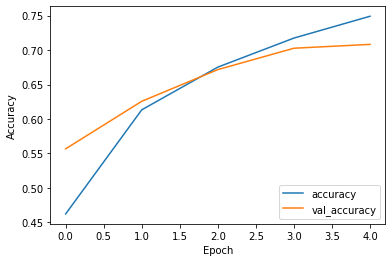

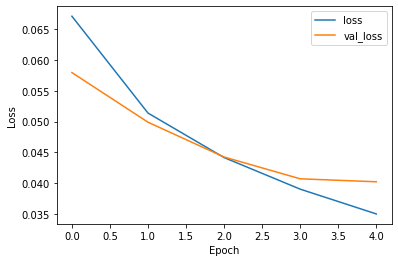

313/313 - 4s - loss: 0.0403 - accuracy: 0.7083
Test accuracy: 0.708299994468689
Test loss: 0.040251195430755615


2021-12-09 11:55:32.599016: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 614400000 exceeds 10% of free system memory.


1563/1563 - 14s - loss: 0.0311 - accuracy: 0.7830
train accuracy: 0.7829599976539612
Train loss: 0.031059807166457176


In [10]:
# Evaluation
plot_accuracy(history,history2)
plt.show()
plot_loss(history,history2)
plt.show()
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print(f"Test accuracy: {test_acc}\nTest loss: {test_loss}")
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
print(f"train accuracy: {train_acc}\nTrain loss: {train_loss}")

if history2:
    parametres['results'] = {
        'acc' : train_acc,
        'val_acc': test_acc,
        'loss': train_loss,
        'val_loss': test_loss,
        'acc_hist': history.history['accuracy']+history2.history['accuracy'],
        'val_acc_hist': history.history['val_accuracy']+history2.history['val_accuracy'],
        'loss_hist': history.history['loss']+history2.history['loss'],
        'val_loss_hist': history.history['val_loss']+history2.history['val_loss']
    }
else:
    parametres['results'] = {
        'acc' : train_acc,
        'val_acc': test_acc,
        'loss': train_loss,
        'val_loss': test_loss,
        'acc_hist': history.history['accuracy'],
        'val_acc_hist': history.history['val_accuracy'],
        'loss_hist': history.history['loss'],
        'val_loss_hist': history.history['val_loss']
    }

## Saving the model

lets save the model in an external file 

In [11]:
#json file containing all model informations
def save_in_json(file_name, model, parametres):
    d = '/'.join(file_name.split('/')[0:-1])
    if d:
        d += '/'
        
    if (not os.path.isfile(file_name)):
        data = {}
    else:
        with open(file_name, 'r') as json_file:
            data = json.load(json_file)
    t=str(time.time()).split('.')[0]
    name = d+f'model-{t}.h5'
    
    data[f'model-{t}.h5'] = {
        'time': str(time.time()).split('.')[0],
        'structure': parametres['structure'],
        'training': parametres['training'],
        'data': parametres['data'],
        'results': parametres['results']
    }
    
    with open(file_name, 'w') as json_file:
        json.dump(data, json_file)
    
    # save the model in the file
    model.save(name)

In [15]:
filename = '../saved-models/informations.json'
save_in_json(filename, model, parametres)